In [5]:
!which python
!python --version
!python -m pip show torch

/home/charlie/miniconda3/envs/pytorch3d/bin/python
Python 3.9.19
Name: torch
Version: 1.13.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/charlie/miniconda3/envs/pytorch3d/lib/python3.9/site-packages
Requires: typing_extensions
Required-by: torchvision


In [2]:
import torch
print(torch.__version__, 'CUDA available:', torch.cuda.is_available(), 'CUDA runtime:', torch.version.cuda)

1.13.0 CUDA available: True CUDA runtime: 11.6


In [25]:
import os 
import kagglehub
print('kagglehub version:', kagglehub.__version__)

data_dir = "/home/charlie/.cache/kagglehub/datasets/smashik/plant-seedlings-classification/versions/1"
if not os.path.exists(data_dir):
    data_dir = kagglehub.dataset_download("smashik/plant-seedlings-classification")
print("Path to dataset files:", data_dir)


kagglehub version: 0.2.7
Path to dataset files: /home/charlie/.cache/kagglehub/datasets/smashik/plant-seedlings-classification/versions/1


In [26]:
import torch
from torch import nn # neural network module
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision import models # pre-defined models
from torchvision.utils import make_grid
from torchvision import transforms as tsfm # provides common image transformations
from torchvision.datasets import ImageFolder # for loading image datasets, need special folder structure

import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path
from IPython import display

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True

In [27]:
# Set Hyperparameters
batch_size = 64
epochs = 50
learning_rate = 0.001
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [35]:
class Train_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = ImageFolder(root=root_dir, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label
    
    def get_classes(self):
        return self.data.classes

    def get_class_to_idx(self):
        return self.data.class_to_idx

class Pred_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = list(Path(root_dir).glob('*.png'))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        img = self.transform(img)
        img = img.unsqueeze(0) # add batch dimension in specific index 
        return img

/home/charlie/.cache/kagglehub/datasets/smashik/plant-seedlings-classification/versions/1/train exists
/home/charlie/.cache/kagglehub/datasets/smashik/plant-seedlings-classification/versions/1/test exists
torch.Size([3, 224, 224]) 0
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
torch.Size([1, 3, 224, 224])


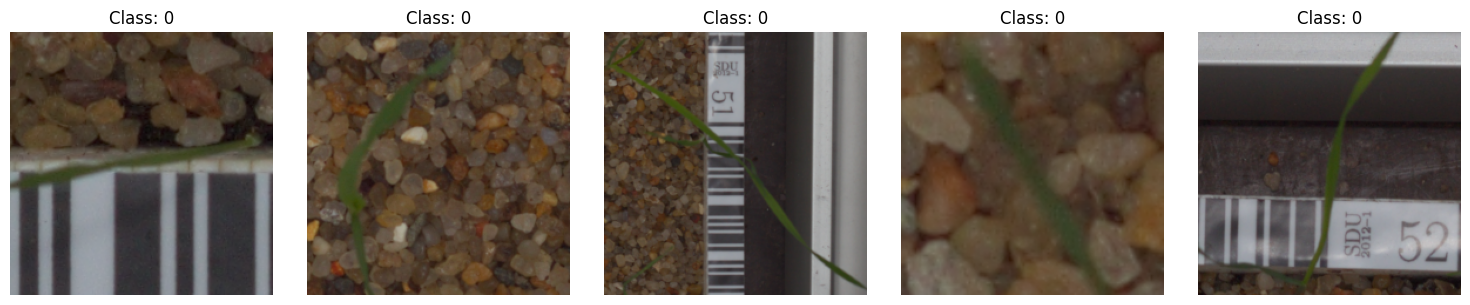

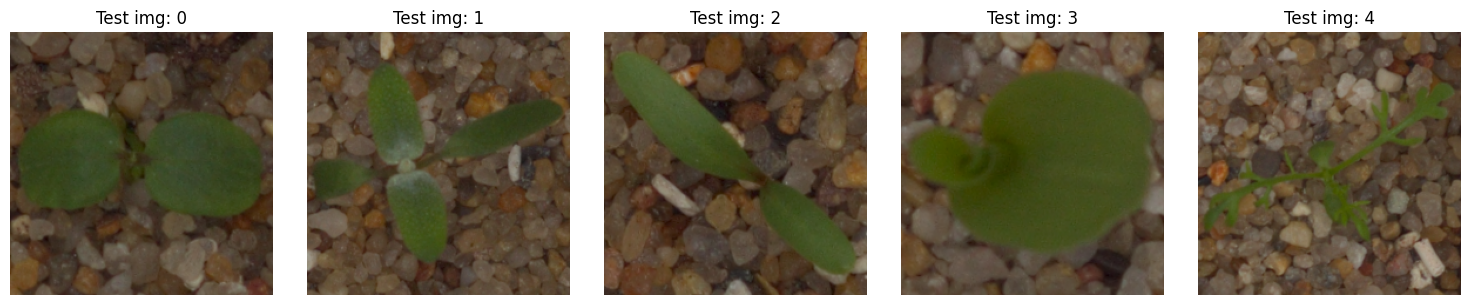

In [48]:
# specified data directories -----------------------------------------------------------------------
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
if os.path.exists(train_dir) or not os.path.exists(test_dir):
    print(train_dir, "exists")
    print(test_dir, "exists")
else:
    raise FileNotFoundError("Train or test directory not found in the dataset path.")

# define image transformations ---------------------------------------------------------------------
transform = tsfm.Compose([tsfm.Resize((224, 224)), tsfm.ToTensor()])

# create dataset instances
whole_set = Train_data(root_dir=train_dir, transform=transform)
img, label = whole_set[0]
print(img.shape, label)
print(whole_set.get_classes())
print(whole_set.get_class_to_idx())

test_set = Pred_data(root_dir=test_dir, transform=transform)
img = test_set[0]
print(img.shape)

# visualize some images from the dataset -----------------------------------------------------------
num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, (img, label) in enumerate(whole_set):
    axs[i].imshow(img.permute(1, 2, 0))  # change from (C, H, W) to (H, W, C) for opendv, matplotlib, numpy image
    axs[i].set_title(f"Class: {label}")
    axs[i].axis("off")
    num_images_to_display -= 1
    if num_images_to_display == 0:
        break
plt.tight_layout()
plt.show()

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, img in enumerate(test_set):
    axs[i].imshow(img[0].permute(1, 2, 0))
    axs[i].set_title(f"Test img: {i}")
    axs[i].axis("off")
    num_images_to_display -= 1
    if num_images_to_display == 0:
        break
plt.tight_layout()
plt.show()

In [50]:
# split dataset into training and validation sets --------------------------------------------------
train_set, valid_set = random_split(whole_set, [0.8, 0.2])

# create data loaders for training and validation sets ---------------------------------------------
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)  # shuffle for training set, randomizes the order of data
valid_loader = DataLoader(valid_set, batch_size=batch_size)

In [80]:
# resnet50 checking --------------------------------------------------------------------------------
resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
print(resnet_model)  # print the model architecture
print()
for layer in resnet_model.children():
    print(layer)  # print all info of the layer in detail
print()
for name, layer in resnet_model.named_children():
    print(name, "→", layer)  # print the layer info including layer name in detail
print()
for name, param in resnet_model.named_parameters():
    print(name, param.shape, param.requires_grad)  # we can choose the specified layers to print info
print()
"""
    conv1 → bn1 → relu → maxpool → layer1 → layer2 → layer3 → layer4 → avgpool → fc
    layer{stage}.{block}.{submodule}.{parameter}
"""
# freeze all layers except the last classification layer (every layer include a few blocks)
for param in resnet_model.parameters():
    param.requires_grad = False
for param in resnet_model.fc.parameters():
    param.requires_grad = True

# freeze all layers except the last layer4 and classification layer
for param in resnet_model.parameters():
    param.requires_grad = False
for param in resnet_model.layer4.parameters():
    param.requires_grad = True
for param in resnet_model.fc.parameters():
    param.requires_grad = True


# print the input feature dimension of the last classification layer
print(resnet_model.fc.in_features)


# create model class using pretrained ResNet-50 ----------------------------------------------------
class resnet_50(nn.Module):
    def __init__(self, num_classes=12):
        super(resnet_50, self).__init__()
        # pytorch built-in models
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # load pretrained weights

        # set model layers trainable, can be back propagated and updated during training
        # default is True
        for param in self.resnet50.parameters():
            param.requires_grad = True

        # redifine/customize last classification layer
        self.resnet50.fc = nn.Linear(
            2048, num_classes
        )  # 2048 is the input feature dimension of last layer, which is fixed for backbone of resnet50,
        # and num_classes is the output dimension, which is defined for classification task

    def forward(self, x):
        # forward pass through the ResNet-50 backbone and classification head
        x = self.resnet50(x)  # the input dimension must be [Batch_size, dimension, height, width]
        """
            About the Batch_size, it represents the number of images processed together in one forward/backward pass.
            It means how many images are forward into the model simultaneously, and how many gradients are computed together during backpropagation.

            In general, the backpropagation algorithm uses the average gradient over the entire batch to update the model parameters.
            If we want to change this behavior, we need to modify the training loop accordingly.

            The detailed information is provided below.
        """
        return x

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [105]:
# test model for debug -----------------------------------------------------------------------------
model = resnet_50(num_classes=12).cuda()  # move model to GPU

# find the first layer dimension
for name, layer in model.resnet50.named_children():
    if name == "conv1":
        print(name, "→", layer)
"""
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

    out_channels will output 64 feature map after the first conv layer, which is defined by the conv layer
"""

x = torch.rand(
    1, 3, 224, 224
).cuda()  # due to the first layer conv1 dimension, need to make sure the dimension is 3, and input one image at once
# print(x)
y = model(x)  # forward pass, the nn.Module define __call__() function to call forward() function
"""
    Because the __call__ function would process the input data before passing it to the forward function,
    including hooks, pre, grad, and post processing, etc.
"""
# print(y)

conv1 → Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
tensor([[[[7.0957e-01, 8.1067e-01, 4.2359e-02,  ..., 8.3933e-01,
           8.6582e-01, 3.9555e-01],
          [6.7240e-01, 5.1877e-01, 3.4316e-01,  ..., 2.7187e-01,
           5.7727e-01, 5.7214e-01],
          [7.6741e-01, 3.7857e-01, 9.6104e-01,  ..., 5.0247e-01,
           2.7393e-01, 2.9958e-01],
          ...,
          [4.6645e-01, 4.5353e-02, 6.0266e-04,  ..., 8.3712e-01,
           7.3729e-01, 8.5512e-01],
          [4.6524e-01, 5.6980e-01, 4.2634e-01,  ..., 1.4433e-01,
           3.3201e-01, 1.1172e-01],
          [7.6458e-01, 9.7775e-01, 4.1940e-01,  ..., 5.3263e-02,
           3.5925e-01, 5.8620e-01]],

         [[3.7278e-01, 1.8675e-02, 5.2052e-01,  ..., 3.9132e-01,
           4.6904e-01, 7.9952e-01],
          [8.4080e-01, 9.1366e-01, 8.8544e-01,  ..., 6.1586e-01,
           3.0873e-01, 5.1513e-01],
          [7.3389e-01, 9.2633e-02, 8.6059e-01,  ..., 7.0017e-01,
           3.9998e-01, 2.